In [1]:
import findspark
findspark.init()

import pyspark
from pyspark import SparkContext
sc =SparkContext()

In [2]:
from pyspark.sql import SQLContext
from pyspark import SparkFiles

url = "https://covid19.who.int/WHO-COVID-19-global-data.csv"
    
sc.addFile(url)
sqlContext = SQLContext(sc)

In [3]:
df = sqlContext.read.csv(SparkFiles.get("WHO-COVID-19-global-data.csv"), header=True, inferSchema=True)

df.printSchema()

root
 |-- Date_reported: string (nullable = true)
 |--  Country_code: string (nullable = true)
 |--  Country: string (nullable = true)
 |--  WHO_region: string (nullable = true)
 |--  New_cases: integer (nullable = true)
 |--  Cumulative_cases: integer (nullable = true)
 |--  New_deaths: integer (nullable = true)
 |--  Cumulative_deaths: integer (nullable = true)



In [4]:
columnas = []
for x in df.columns:
    columnas.append(x.strip())

df = df.toDF(*columnas)

df.printSchema()

root
 |-- Date_reported: string (nullable = true)
 |-- Country_code: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- WHO_region: string (nullable = true)
 |-- New_cases: integer (nullable = true)
 |-- Cumulative_cases: integer (nullable = true)
 |-- New_deaths: integer (nullable = true)
 |-- Cumulative_deaths: integer (nullable = true)



In [5]:
df.select(columnas).show()

+-------------+------------+-----------+----------+---------+----------------+----------+-----------------+
|Date_reported|Country_code|    Country|WHO_region|New_cases|Cumulative_cases|New_deaths|Cumulative_deaths|
+-------------+------------+-----------+----------+---------+----------------+----------+-----------------+
|   2020-02-24|          AF|Afghanistan|      EMRO|        5|               5|         0|                0|
|   2020-02-25|          AF|Afghanistan|      EMRO|        0|               5|         0|                0|
|   2020-02-26|          AF|Afghanistan|      EMRO|        0|               5|         0|                0|
|   2020-02-27|          AF|Afghanistan|      EMRO|        0|               5|         0|                0|
|   2020-02-28|          AF|Afghanistan|      EMRO|        0|               5|         0|                0|
|   2020-02-29|          AF|Afghanistan|      EMRO|        0|               5|         0|                0|
|   2020-03-01|          AF|

In [6]:
n_paises = df.select('Country').distinct().count()

df.groupby("Country").count().sort("count", ascending=True).show(n_paises)

+--------------------+-----+
|             Country|count|
+--------------------+-----+
|             Lesotho|   79|
|             Comoros|   92|
|          Tajikistan|   92|
|               Yemen|  113|
|Saint Pierre and ...|  115|
|Sao Tome and Prin...|  117|
|         South Sudan|  117|
|Falkland Islands ...|  118|
|Bonaire, Sint Eus...|  119|
|              Malawi|  120|
|            Botswana|  122|
|             Burundi|  122|
|        Sierra Leone|  122|
|Northern Mariana ...|  125|
|       Guinea-Bissau|  128|
|                Mali|  128|
|Saint Kitts and N...|  128|
|British Virgin Is...|  128|
|            Anguilla|  128|
|               Libya|  129|
|            Dominica|  130|
|Lao People's Demo...|  130|
|              Belize|  130|
|             Myanmar|  130|
|Turks and Caicos ...|  130|
|Syrian Arab Republic|  131|
|             Grenada|  131|
|          Mozambique|  131|
|          Madagascar|  133|
|              Angola|  133|
|              Uganda|  133|
|             

In [7]:
from pyspark.sql.types import DateType

df = df.withColumn("Date_reported", df["Date_reported"].cast(DateType()))

df.printSchema()

root
 |-- Date_reported: date (nullable = true)
 |-- Country_code: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- WHO_region: string (nullable = true)
 |-- New_cases: integer (nullable = true)
 |-- Cumulative_cases: integer (nullable = true)
 |-- New_deaths: integer (nullable = true)
 |-- Cumulative_deaths: integer (nullable = true)



In [8]:
# ultimo reporte fecha
df.groupBy('Country').agg({'Date_reported': 'max'}).show()


+-------------------+------------------+
|            Country|max(Date_reported)|
+-------------------+------------------+
|        Afghanistan|        2020-07-31|
|            Albania|        2020-07-31|
|            Algeria|        2020-07-31|
|            Andorra|        2020-07-31|
|             Angola|        2020-07-31|
|           Anguilla|        2020-07-31|
|Antigua and Barbuda|        2020-07-31|
|          Argentina|        2020-07-31|
|            Armenia|        2020-07-31|
|              Aruba|        2020-07-31|
|          Australia|        2020-07-31|
|            Austria|        2020-07-31|
|         Azerbaijan|        2020-07-31|
|            Bahamas|        2020-07-31|
|            Bahrain|        2020-07-31|
|         Bangladesh|        2020-07-31|
|           Barbados|        2020-07-31|
|            Belarus|        2020-07-31|
|            Belgium|        2020-07-31|
|             Belize|        2020-07-31|
+-------------------+------------------+
only showing top

In [9]:
# ultimo reporte fecha, varias columnas
from pyspark.sql import functions as F

df.groupBy('Country').agg(F.max(df.Date_reported), F.last(df.New_cases)).show(100)


+--------------------+------------------+----------------------+
|             Country|max(Date_reported)|last(New_cases, false)|
+--------------------+------------------+----------------------+
|         Afghanistan|        2020-07-31|                     0|
|             Albania|        2020-07-31|                    92|
|             Algeria|        2020-07-31|                   602|
|             Andorra|        2020-07-31|                     4|
|              Angola|        2020-07-31|                    31|
|            Anguilla|        2020-07-31|                     0|
| Antigua and Barbuda|        2020-07-31|                     5|
|           Argentina|        2020-07-31|                  5641|
|             Armenia|        2020-07-31|                   354|
|               Aruba|        2020-07-31|                     0|
|           Australia|        2020-07-31|                   721|
|             Austria|        2020-07-31|                   163|
|          Azerbaijan|   

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from matplotlib import rcParams
rcParams['figure.figsize'] = 15, 5


# crear listas para matplotlib
# grafico de evolucion historica de Cumulative_cases y Cumulative_deaths

# 1 universal
# 2 para una lista de paises seleccionados al azar, digamos 5 paises
# 3 para una lista de paises de su preferencia

In [11]:
# universal
# total general
print('Total mundial')
df.groupBy().agg(F.sum(df.New_cases), F.sum(df.New_deaths)).show()


Total mundial
+--------------+---------------+
|sum(New_cases)|sum(New_deaths)|
+--------------+---------------+
|      17106007|         668910|
+--------------+---------------+



In [12]:
df.printSchema()

root
 |-- Date_reported: date (nullable = true)
 |-- Country_code: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- WHO_region: string (nullable = true)
 |-- New_cases: integer (nullable = true)
 |-- Cumulative_cases: integer (nullable = true)
 |-- New_deaths: integer (nullable = true)
 |-- Cumulative_deaths: integer (nullable = true)



In [13]:
# lo que muestra los medios
df.groupBy('Country_code').agg(F.sum(df.New_cases), F.sum(df.New_deaths)).show(300)

+------------+--------------+---------------+
|Country_code|sum(New_cases)|sum(New_deaths)|
+------------+--------------+---------------+
|          AF|         36542|           1271|
|          AL|          5197|            154|
|          DZ|         29831|           1200|
|          AD|           922|             52|
|          AO|          1109|             51|
|          AI|             3|              0|
|          AG|            91|              3|
|          AR|        178996|           3311|
|          AM|         38550|            738|
|          AW|           119|              3|
|          AU|         16303|            189|
|          AT|         21009|            718|
|          AZ|         31560|            441|
|          BS|           484|             11|
|          BH|         40755|            146|
|          BD|        234889|           3083|
|          BB|           110|              7|
|          BY|         67808|            559|
|          BE|         67913|     

### Graficos

In [14]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 15, 5

import sys
from pyspark.sql.window import Window

def grafico(pais=''):
    
    if len(pais) > 0:
        pru = df.filter(df.Country_code==pais).select(['Date_reported', 'Cumulative_cases', 'Cumulative_deaths'])
        titulo = df.filter(df.Country_code==pais).select(['Country']).collect()[0]['Country']
    else:
        pru = df.groupBy('Date_reported').agg(F.sum(df.New_cases), F.sum(df.New_deaths)).sort('Date_reported')
        pru = pru.withColumn('Cumulative_cases', F.sum(pru['sum(New_cases)']).over(Window.partitionBy().orderBy().rowsBetween(-sys.maxsize, 0)))
        pru = pru.withColumn('Cumulative_deaths', F.sum(pru['sum(New_deaths)']).over(Window.partitionBy().orderBy().rowsBetween(-sys.maxsize, 0)))

        titulo = "Global"

    fecha = [row for row in pru.select('Date_reported').collect()]

    tot_casos = [row for row in pru.select('Cumulative_cases').collect()]

    tot_fails = [row for row in pru.select('Cumulative_deaths').collect()]
    
    x = fecha
    y = tot_casos
    z = tot_fails
    
    plt.plot(x, y, color='blue', label='Total Casos')
    plt.plot(x, z, color='red', label='total fallec')

    plt.title(titulo)
    plt.xticks(rotation=60)
    plt.ylabel('Number of cases',fontsize=15)
    plt.xlabel('Dates',fontsize=15)
    plt.legend()

    plt.show()

In [15]:
paises = df.select(['Country', 'Country_code']).distinct()

paises_nombre = [row for row in paises.select('Country').collect()]

paises_codigo = [row for row in paises.select('Country_code').collect()]

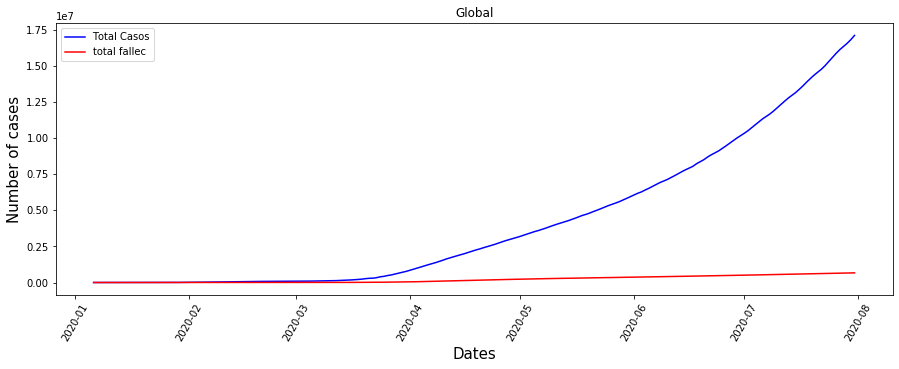

In [16]:
# 1 universal
grafico()

In [17]:
# 2 para una lista de paises seleccionados al azar, digamos 5 paises

t1 = paises.sample(False,  .02).select('Country_code')

t1.show()



+------------+
|Country_code|
+------------+
|          FR|
|          PK|
|          MF|
|          SN|
|          ZW|
+------------+



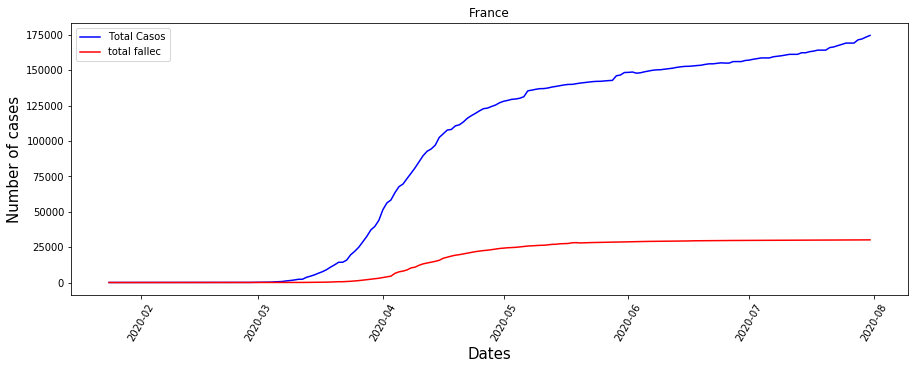

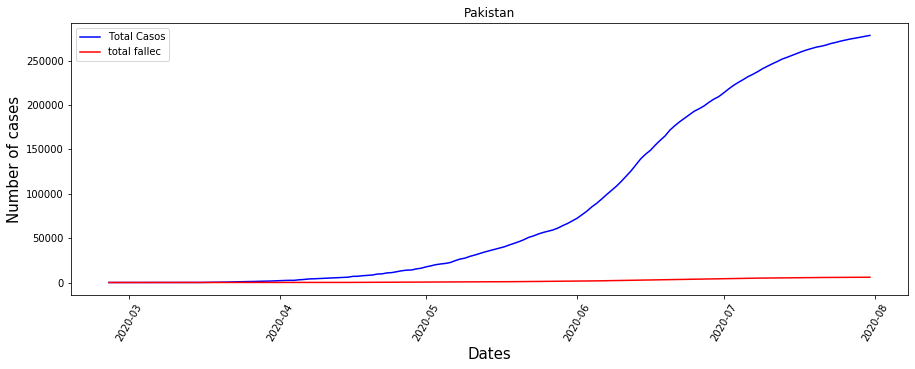

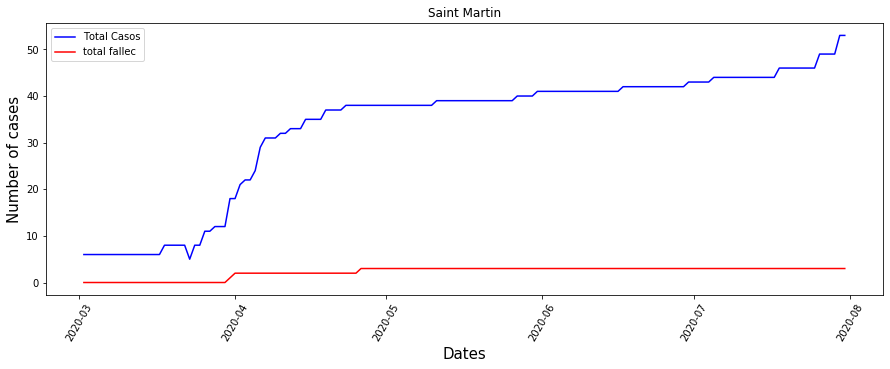

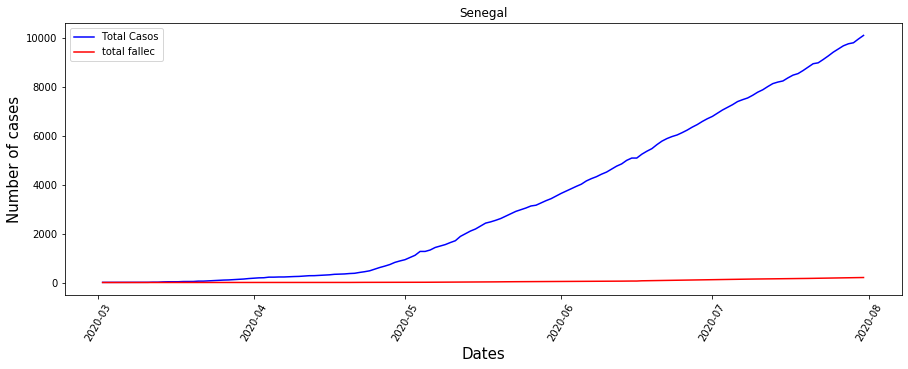

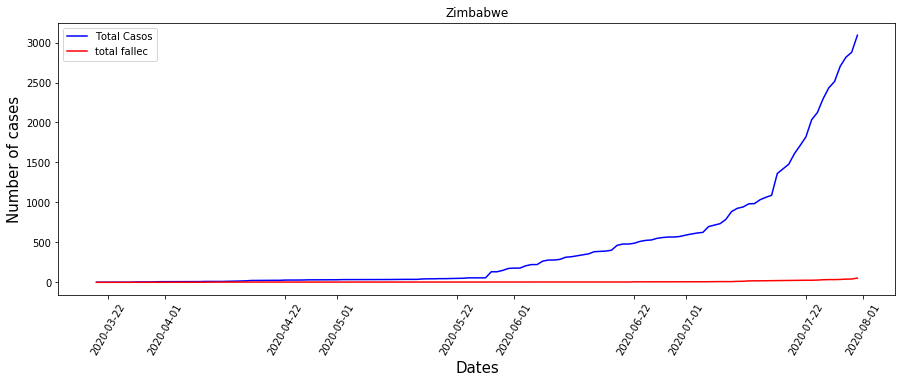

In [18]:
cod_pais = [row.Country_code for row in t1.select('Country_code').collect()]

for pais in cod_pais:
    grafico(pais)

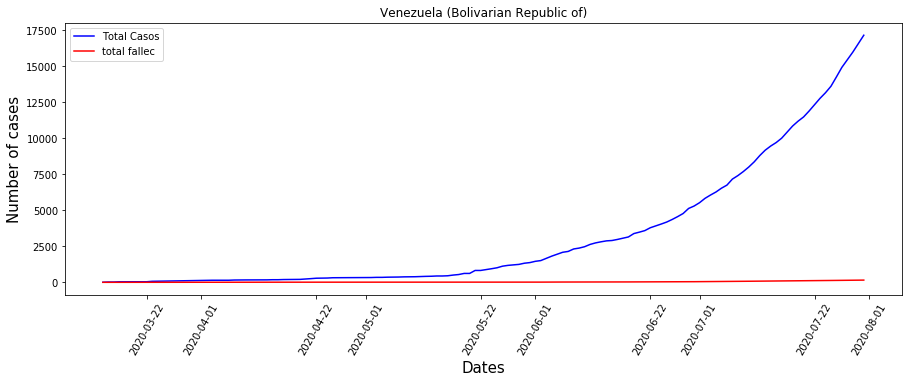

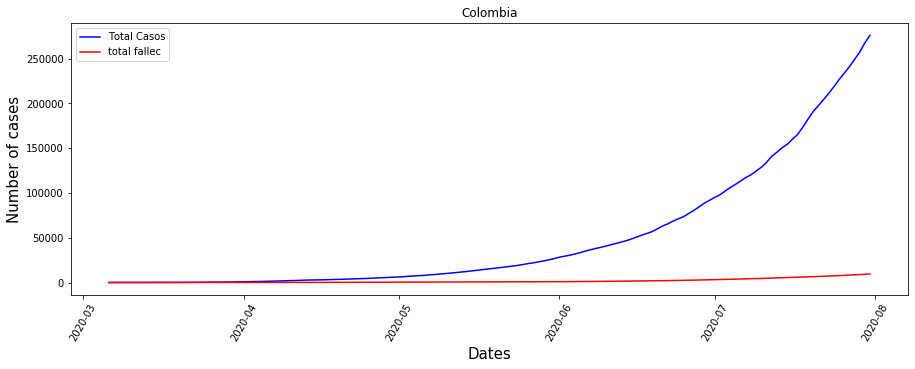

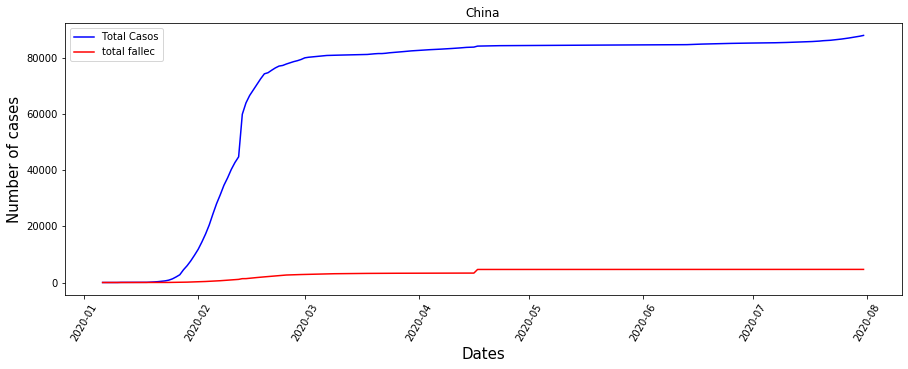

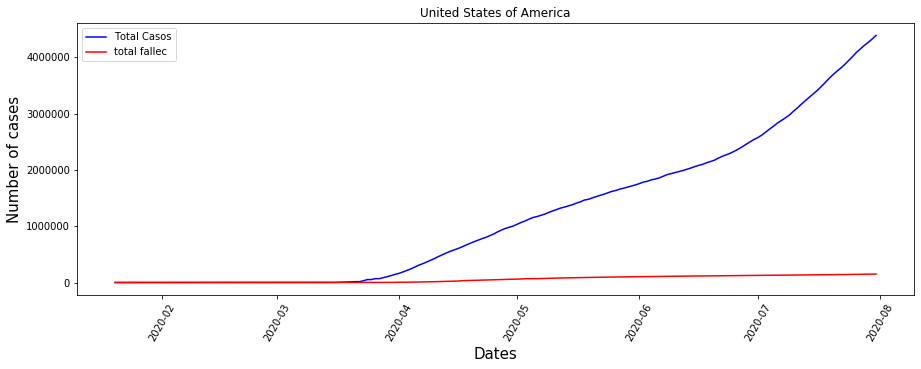

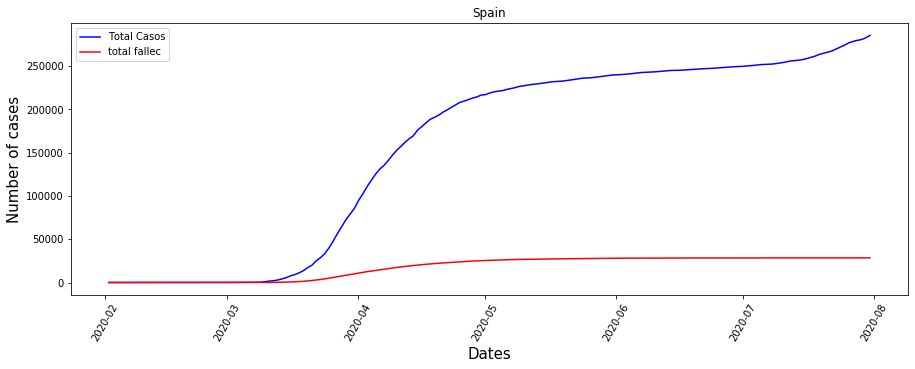

In [19]:
# 3 para una lista de paises de su preferencia

cod_pais = ['VE', 'CO', 'CN', 'US',  'ES']

for pais in cod_pais:
    grafico(pais)

In [23]:
paises.show(300)

+--------------------+------------+
|             Country|Country_code|
+--------------------+------------+
|         Afghanistan|          AF|
|             Albania|          AL|
|             Algeria|          DZ|
|             Andorra|          AD|
|              Angola|          AO|
|            Anguilla|          AI|
| Antigua and Barbuda|          AG|
|           Argentina|          AR|
|             Armenia|          AM|
|               Aruba|          AW|
|           Australia|          AU|
|             Austria|          AT|
|          Azerbaijan|          AZ|
|             Bahamas|          BS|
|             Bahrain|          BH|
|          Bangladesh|          BD|
|            Barbados|          BB|
|             Belarus|          BY|
|             Belgium|          BE|
|              Belize|          BZ|
|               Benin|          BJ|
|             Bermuda|          BM|
|              Bhutan|          BT|
|Bolivia (Plurinat...|          BO|
|Bonaire, Sint Eus...|      